<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Diffusion_RL/implementation%20attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops
!pip install equinox
!pip install optax
!pip install diffrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 971.9 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 KB 5.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 10.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 KB 13.7 MB/s eta 0:00:00


In [2]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx
import numpy as np

In [3]:
key = jr.PRNGKey(2023)

Data generation

In [11]:
def Gaussian(N, mu, sigma, key):
    sg = jr.normal(key, shape=(N,2))
    g = mu + sigma * sg
    return g

In [12]:
mean1 = jnp.array((0.0, 0.8))
mean2 = jnp.array((0.0, -0.8))
mean3 = jnp.array((0.8, 0.0))
mean4 = jnp.array((-0.8, 0.0))
std = jnp.array((0.05, 0.05))

In [13]:
s1 = Gaussian(2500, mean1, std, key)
s2 = Gaussian(2500, mean2, std, key)
s3 = Gaussian(2500, mean3, std, key)
s4 = Gaussian(2500, mean4, std, key)

In [14]:
samples = jnp.concatenate([s1, s2, s3, s4], axis=0)

In [15]:
import matplotlib.pyplot as plt

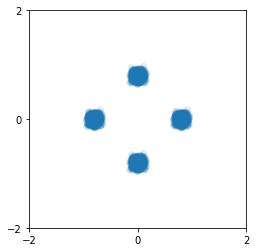

In [16]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

Add reward

In [4]:
def rewGau(N, mu, sigma, key):
    sg = jr.normal(key, shape=(N,1))
    g = mu + sigma * sg
    return g

In [8]:
r1 = rewGau(2500, 3.0, 0.5, key)
r2 = rewGau(2500, 5.0, 0.5, key)
r3 = rewGau(2500, 1.5, 0.5, key)
r4 = rewGau(2500, 0.0, 0.5, key)

In [9]:
rewards = jnp.concatenate([r1, r2, r3, r4], axis=0)

In [69]:
rewards.shape

(10000, 1)

Join actions and rewards

In [71]:
comb = jnp.concatenate([samples, rewards], axis=1)

BC-Diffusion

In [156]:
class NeuralNet(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    t = einops.repeat(t, "-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [ ]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)

In [ ]:
def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [120]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

In [47]:
def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm, :]
            start = end
            end = start + batch_size

In [ ]:
t1=10.0
# Optimisation hyperparameters
num_steps=20_000
lr=3e-4
batch_size=256
print_every=500
# Sampling hyperparameters
dt0=0.1
#sample_size=10
# Seed
seed=2023

In [ ]:
x = samples.copy()

In [ ]:
model_key, train_key, loader_key, sample_key = jr.split(key, 4)
data = x
data_shape = data.shape[1:]

In [ ]:
model = NeuralNet(4, 2, 512, 4, key)

In [ ]:
int_beta = lambda t: t
weight = lambda t: 1 - jnp.exp(-int_beta(t))  
opt = optax.adabelief(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [ ]:
total_value = 0
total_size = 0
losses = [0]
i=0
ls=2


for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
      value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
      total_value += value.item()
      total_size += 1

      if (step % print_every) == 0 or step == num_steps - 1:
              
          print(f"Step={step} Loss={total_value / total_size}")
          if step != 0 :
              ls = total_value / total_size
              if jnp.absolute(ls - losses[i]) > 5e-5:
                  i += 1
                  losses.append(ls)
              else:
                  print("Early stopping intervened")
                  break
          else:
             continue
          total_value = 0
          total_size = 0

In [175]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [ ]:
sample_key = jr.split(sample_key, 2_000)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)

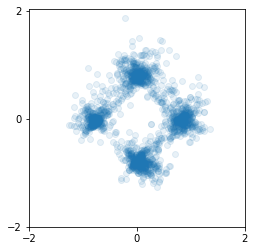

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

In [ ]:
# def main(
#     t1=10.0,
#     # Optimisation hyperparameters
#     num_steps=8_000,
#     lr=3e-4,
#     batch_size=256,
#     print_every=500,
#     # Sampling hyperparameters
#     dt0=0.1,
#     # Seed
#     seed=2023,
# ):
#     key = jr.PRNGKey(seed)
   
#     x = samples.copy()
#     model_key, train_key, loader_key, sample_key = jr.split(key, 4)
#     data = x
#     data_shape = data.shape[1:]

#     model = NeuralNet(4, 2, 512, 4, key)

#     int_beta = lambda t: t  
#     weight = lambda t: 1 - jnp.exp(-int_beta(t)) 
#     opt = optax.adabelief(lr)
    
#     opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

#     total_value = 0
#     total_size = 0
#     for step, data in zip(
#         range(num_steps), dataloader(data, batch_size, key=loader_key)
#     ):
#         value, model, train_key, opt_state = make_step(
#             model, weight, int_beta, data, t1, train_key, opt_state, opt.update
#         )
#         total_value += value.item()
#         total_size += 1
#         if (step % print_every) == 0 or step == num_steps - 1:
#             print(f"Step={step} Loss={total_value / total_size}")
#             total_value = 0
#             total_size = 0


Critic Network

In [22]:
from typing import Callable

class Lambda1(eqx.Module):
    fn: Callable
    
    def __call__(self, x, *, key=None):
        return x * jnp.tanh(self.fn(x))

In [23]:
class Critic1Net(eqx.Module):
  mlp: eqx.nn.Sequential

  def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
    (rng,) = jr.split(key, 1)
    self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=key),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=key),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=key),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, out_size, key=key)])
  def __call__(self, x):
    return self.mlp(x)

In [24]:
class Critic2Net(eqx.Module):
  mlp: eqx.nn.Sequential

  def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
    (rng,) = jr.split(key, 1)
    self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=rng),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=rng),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=rng),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, out_size, key=rng)])
  def __call__(self, x):
    return self.mlp(x)

In [43]:
def ema(new_weight: jax.Array, target_weight: jax.Array, beta: float) -> jax.Array:
  update_w = target_weight * beta + (1 - beta)* new_weight
  return update_w

def EMA_update(new_model, target_model, init_fn, beta):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  new_weights = get_weights(new_model)
  target_weights = get_weights(target_model)
  updated_weights = [init_fn(n_weight, t_weight, beta) for n_weight, t_weight in zip(new_weights, target_weights)]
  new_model = eqx.tree_at(get_weights, target_model, updated_weights)
  return new_model


In [28]:
eg = jr.normal(key, shape=(2,))

In [30]:
Q1 = Critic1Net(2, 1, 256, key)

In [31]:
Q1(eg)

Array([0.03285572], dtype=float32)

In [ ]:
EMA_update(Q1, Q1, ema, 0.5)

Target networks

In [157]:
class NeuralNet_T(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    t = einops.repeat(t, "-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [51]:
class Critic1Net_T(eqx.Module):
  mlp: eqx.nn.Sequential

  def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
    (rng,) = jr.split(key, 1)
    self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=key),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=key),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=key),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, out_size, key=key)])
  def __call__(self, x):
    return self.mlp(x)

In [52]:
class Critic2Net_T(eqx.Module):
  mlp: eqx.nn.Sequential

  def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
    (rng,) = jr.split(key, 1)
    self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=rng),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=rng),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=rng),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, out_size, key=rng)])
  def __call__(self, x):
    return self.mlp(x)

Parameters

In [172]:
iterations = 1_000
data = comb
batch_size =256
t1 = 10.0
dt0 = 0.1
data_shape  = (2,)
discount = 1
lr = 3e-3

In [114]:
int_beta = lambda t: t
weight = lambda t: 1 - jnp.exp(-int_beta(t))  

Initilialisations

In [199]:
c_Q1 = Critic1Net(2, 1, 256, key)
c_Q2 = Critic2Net(2, 1, 256, key)

t_Q1 = Critic1Net_T(2, 1, 256, key)
t_Q2 = Critic2Net_T(2, 1, 256, key)

In [200]:
c_pi = NeuralNet(4, 2, 256, 4, key)
t_pi = NeuralNet_T(4, 2, 256, 4, key)

In [201]:
opt = optax.adabelief(lr)


opt_state_q1c = opt.init(eqx.filter(c_Q1, eqx.is_inexact_array))
opt_state_q2c = opt.init(eqx.filter(c_Q2, eqx.is_inexact_array))

opt_state_q1t = opt.init(eqx.filter(t_Q1, eqx.is_inexact_array))
opt_state_q2t = opt.init(eqx.filter(t_Q2, eqx.is_inexact_array))

opt_state_cpi = opt.init(eqx.filter(c_pi, eqx.is_inexact_array))

Train

In [ ]:
# for _ in range(iterations):

In [202]:
def c_loss(t_Q, next_action, current_q1, current_q2, other):

    target_q = jnp.minimum(jax.vmap(t_Q)(next_action), other)
    target_q = (reward + discount * target_q)

    critic_loss = jnp.mean((current_q1 - target_q)**2) + jnp.mean((current_q2 - target_q)**2)
    return critic_loss

In [203]:
def target_update(new_model, target_model):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  target_weights = get_weights(target_model)
  model = eqx.tree_at(get_weights, new_model, target_weights)
  return model

In [205]:
dataset_size = data.shape[0]
indices = jnp.arange(dataset_size)
perm = jr.permutation(key, indices)
(key,) = jr.split(key, 1)
p = perm[0:batch_size]
dat = data[p]
action, reward = jnp.split(dat, [2], axis=1)

"""Q-Training"""   

current_q1 = jax.vmap(c_Q1)(action)
current_q2 = jax.vmap(c_Q2)(action)


sample_key = jr.split(sample_key, batch_size)
sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape , dt0, t1)
next_action = jax.vmap(sample_fn)(sample_key)

(sample_key,) = jr.split(key, 1)
    
t_1 = jax.vmap(t_Q1)(next_action)
t_2 = jax.vmap(t_Q2)(next_action)


    
target_q = jnp.minimum(t_1, t_2)

target_q = (reward + discount * target_q)


critic_loss = jnp.mean((current_q1 - target_q)**2) + jnp.mean((current_q2 - target_q)**2)


loss_fn = eqx.filter_value_and_grad(c_loss)


loss, grads = loss_fn(t_Q1, next_action, current_q1, current_q2, t_2)
updates, opt_state_q1t = opt.update(grads, opt_state_q1t)
c_Q1 = target_update(c_Q1, updates)

loss,grads = loss_fn(t_Q2, next_action, current_q2, current_q2, t_1)
updates, opt_state_q2t = opt.update(grads, opt_state_q2t)
c_Q2 = target_update(c_Q2, updates)



